# Data exploration

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import re

In [130]:
hf = h5py.File(filename, "r")
a_group_key = list(hf.keys())[0]
re_m = re.match("Event_\[(\d*)\]", a_group_key)
int(re_m.groups()[0])

0

In [136]:
filename = "data/Mg22_alphaalpha_digiSim.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    #print("All keys: %s" % f.keys())
    print("Total number of events:", len(f.keys()))
    a_group_key = list(f.keys())[0]

    print("Extracting data for key:", a_group_key)
    # Get the data
    data_0 = list(f[a_group_key])
    #print(f.keys()) 

    list_data = []
    dict_data = {}
    y = []
    
    for i, key in enumerate(f.keys()):
        #if i > 10:
        #    break
        #print(key)
        re_m = re.match("Event_\[(\d*)\]", key)
        event = int(re_m.groups()[0])
        #print("Event:", event)

        tmp = np.asarray(list(f[key]))        
        dict_data[event] = tmp         
        list_data.append(tmp)
        y.append(event % 2)
    
    
y = np.asarray(y)[:,np.newaxis]

Total number of events: 2000
Extracting data for key: Event_[0]


### Data structure

In [106]:
display(pd.DataFrame(dict_data[8]))

,x,y,z,t,A,trackID
0,-68.715302,31.205349,320.0,160,235.834429,0
1,-71.169418,26.954693,320.0,160,23.752660,0
2,-71.169418,32.554501,320.0,160,227.466740,0
3,-73.623535,31.205347,320.0,160,248.377997,0
4,-66.261185,26.954693,322.0,161,216.785063,0
...,...,...,...,...,...,...
449,-4.908247,-5.701409,898.0,449,111.221494,0
450,-2.454130,-1.450752,898.0,449,1594.985254,0
451,-12.270597,-1.450752,900.0,450,6.590222,0
452,-4.908247,2.799905,900.0,450,175.505943,0


### Length of events

In [50]:
length = []
for i, event in enumerate(dict_data):
    length.append(len(event))
length = np.asarray(length)

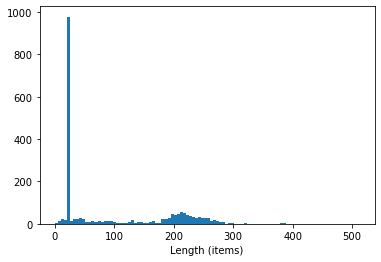

In [66]:
plt.figure()
plt.hist(length, bins=100)
plt.xlabel("Length (items)")
plt.show()

## Visualisation

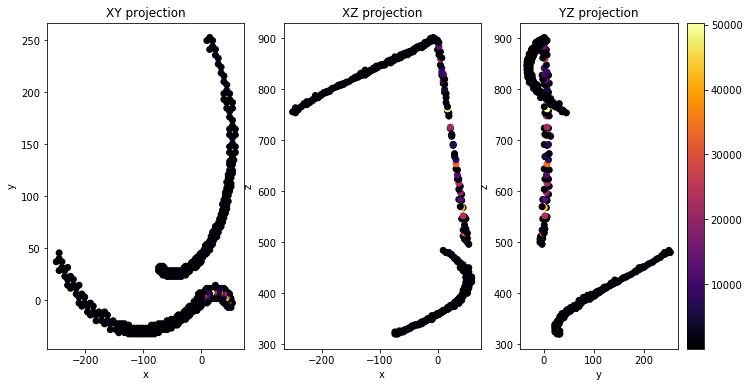

In [117]:
event_i = 8

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(131)
sc = plt.scatter(dict_data[event_i]["x"], dict_data[event_i]["y"], c=dict_data[event_i]["A"], cmap='inferno')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("XY projection")

ax = plt.subplot(132)
sc = plt.scatter(dict_data[event_i]["x"], dict_data[event_i]["z"], c=dict_data[event_i]["A"], cmap='inferno')
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_title("XZ projection")

ax = plt.subplot(133)
sc = plt.scatter(dict_data[event_i]["y"], dict_data[event_i]["z"], c=dict_data[event_i]["A"], cmap='inferno')
ax.set_xlabel("y")
ax.set_ylabel("z")
ax.set_title("YZ projection")

cbar = fig.colorbar(sc, orientation='vertical')    

plt.show()

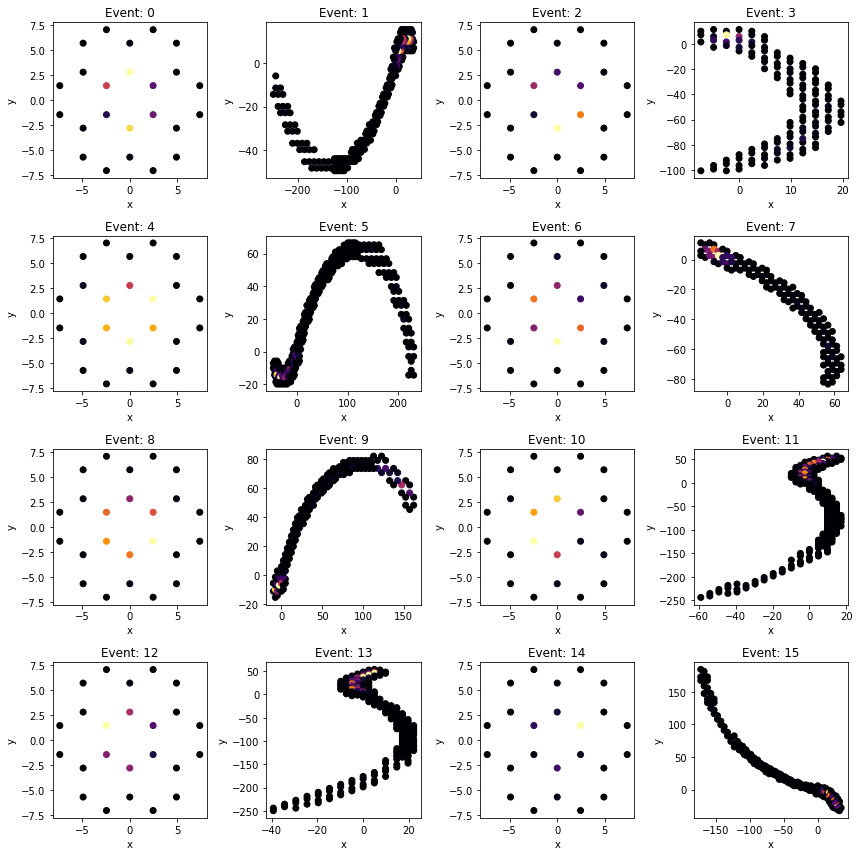

In [141]:
n_rows, n_cols = 4, 4

fig = plt.figure(figsize=(12,12))

for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    sc = plt.scatter(dict_data[i]["x"], dict_data[i]["y"], c=dict_data[i]["A"], cmap='inferno')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Event: {}".format(i))

plt.tight_layout()
plt.show()

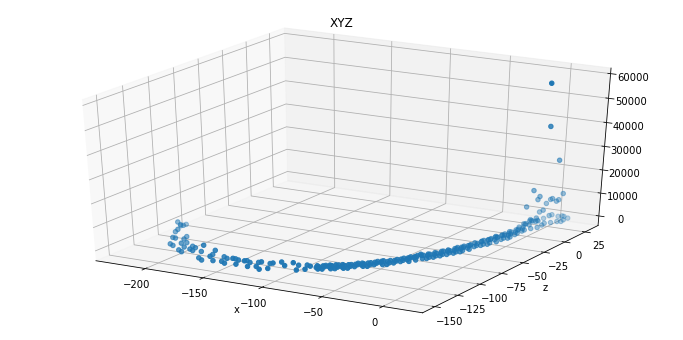

In [116]:
from mpl_toolkits.mplot3d import Axes3D
event_i = 13

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(dict_data[event_i]["x"], dict_data[event_i]["y"],dict_data[event_i]["A"])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylabel("z")
ax.set_title("XYZ")
plt.show()

## Discretization

In [75]:
import utils
%load_ext autoreload
%autoreload 1
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
X_DISC, Y_DISC =